In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline

# Soap films and minimal surfaces

![](min_surface.gif)

A 2D surface sitting in 3D space can be approximated by a triangle mesh.
In its simplest form this can be a set of vertices indexed by $i\in\{0,1,2,...,n-1\}$
together with vertex positions $v[i]\in\mathbb{R}^3$ and triangles as triples of indices $(i,j,k)$.
From this data one can compute the total surface area as a sum over all triangle areas:

In [2]:
def surface_area(v, triangles):
    def triangle_area(triangle):
        i, j, k = triangle
        return 0.5 * jnp.linalg.norm(jnp.cross(v[j]-v[i], v[k]-v[i]))
    return jnp.sum(jax.vmap(triangle_area)(triangles))

Soap films can be modeled as surfaces minimizing their area. 
Starting from an initial triangle mesh,
here we use gradient descent to iteratively optimize interior vertex positions
while keeping prescribed boundary vertices fixed.

In [3]:
def minimize(loss, v, c, step_size, num_steps, cb=lambda i, x: None, cb_every=1000):
    """Minimization by gradient descent."""
    @jax.jit
    def step(v):
        g = jax.grad(loss)(v)
        constrained_g = g.at[c].set(0.)
        return v - step_size * constrained_g
    for i in range(num_steps):
        v = step(v)
        if i % cb_every == 0: cb(i, v)
    return v

## Initial surface

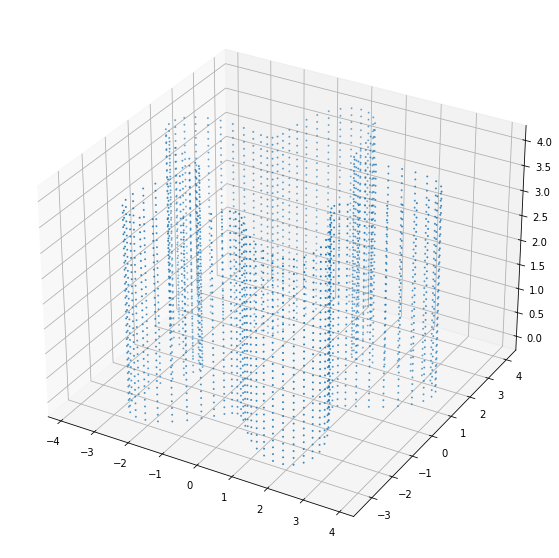

In [4]:
na, nb = 100, 30
a = jnp.linspace(0, 2*jnp.pi, num=na, endpoint=False)
b = jnp.linspace(0, 4, num=nb)
a, b = jnp.meshgrid(a, b)
a, b = a.flatten(), b.flatten()

# collect top and bottom row indices to constrain
c = jnp.where((b == b.min()) | (b == b.max()))[0]

## cylinder
# x = jnp.cos(a)
# y = jnp.sin(a)
# z = b

# star
s = 3 + jnp.sin(5*a)
x = s * jnp.cos(a)
y = s * jnp.sin(a)
z = b

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter3D(x, y, z, s=1)

In [5]:
def make_cylinder_triangulation(ni, nj):
    """Generate a 2D triangulation with left-right gluing."""
    def tri(i, j):
        return jnp.array([[i*nj+j,  i*nj+(j+1)%nj, (i+1)*nj+(j+1)%nj], 
                          [i*nj+j,     (i+1)*nj+j, (i+1)*nj+(j+1)%nj]])
    triangles = jax.vmap(jax.vmap(tri, (None, 0)), (0, None))(jnp.arange(ni-1), jnp.arange(nj))
    return triangles.reshape(-1, 3)

v = jnp.vstack((x, y, z)).T
triangles = make_cylinder_triangulation(nb, na)
print("vertex positions:    ", v.shape)
print("triangles:           ", triangles.shape)
print("constrained vertices:", c.shape)

vertex positions:     (3000, 3)
triangles:            (5800, 3)
constrained vertices: (200,)


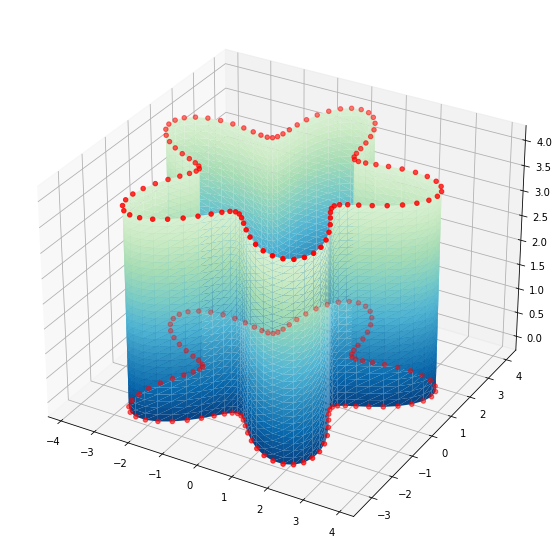

In [6]:
def plot_mesh(v, triangles, c=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    kwargs = dict(cmap=plt.cm.GnBu_r, vmin=v[:,2].min(), vmax=v[:,2].max()*1.2)
    ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles=triangles, **kwargs)
    ax.scatter3D(v[c,0], v[c,1], v[c,2], c="red")

plot_mesh(v, triangles, c)

## Minimize the surface area

In [7]:
loss = lambda v: surface_area(v, triangles)
cb = lambda i, v: print(f"i={i} loss={loss(v)}")
v2 = minimize(loss, v, c, step_size=1e-1, num_steps=10000, cb=cb, cb_every=1000)

i=0 loss=113.60426330566406
i=1000 loss=79.60592651367188
i=2000 loss=76.50721740722656
i=3000 loss=74.66070556640625
i=4000 loss=72.79273223876953
i=5000 loss=73.46154022216797
i=6000 loss=74.27364349365234
i=7000 loss=74.36503601074219
i=8000 loss=74.12223052978516
i=9000 loss=73.84172058105469


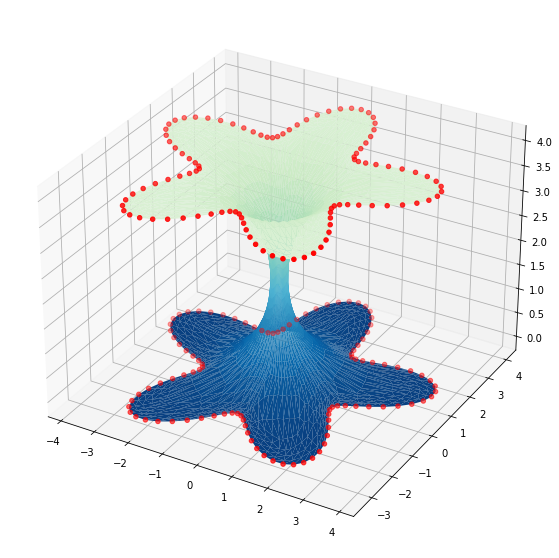

In [8]:
plot_mesh(v2, triangles, c)

## GIF

In [9]:
from IPython.display import clear_output
import gif

frames = []

@gif.frame
def plot(i, v):
    clear_output(True)
    plot_mesh(v, triangles, c)
    plt.title(f"area = {surface_area(v, triangles):.4f}")
    
def callback(i, v):
    print(f"t={i}")
    frame = plot(i, v)
    frames.append(frame)

num_steps = 6000
v2 = minimize(loss, v, c, step_size=1e-1, num_steps=num_steps, cb=callback, cb_every=100)
callback(num_steps, v2) # one final callback on the result

t=6000


In [10]:
gif.save(frames, 'min_surface.gif', duration=1, unit="s", between="startend")